# Krypton Lifetime maps

### Author:  JMH, JJGC

### Software: KrCalib : https://github.com/nextic/KrCalib/

In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
import time
import warnings
import datetime 
print("Last updated on ", time.asctime())

Last updated on  Mon Nov 11 17:37:20 2019


### Logger

In [2]:
import logging


logging.basicConfig(format='%(asctime)s | %(levelname)s : %(message)s',
                     level=logging.INFO, stream=sys.stdout)

logging.info('Hello world!')


2019-11-11 17:37:20,349 | INFO : Hello world!


### Input files

In [3]:
from krcal.core.kr_types import KrFileName
import subprocess

run_number = 7414
num_files = 6211
analysis_tag = 'Prgav190819'
input_tag = 'st190819'

# For testing
# run_number  = 7435
# num_files = 8895
# analysis_tag = 'Prgav190819'
# input_tag = 'st190819' # we allow analysis using selection and filtering from a different tag

num_xy_bins = 50
regularize = True

# Can conditionally allow 100 x 100, if you like
# if num_files > 7729:
#     num_xy_bins = 100

t_start = time.time()

lifetime_limits = (3000, 8000)
e0_limits = (7000, 14000)
e0_limits_rphi = (12000, 14000)

input_path  = f"$IC_DATA/"+input_tag+"/dst"
output_path = f"$IC_DATA/"+analysis_tag+"/ldst"
map_path    = f"$IC_DATA/"+analysis_tag+"/maps"

output_plots = f"$IC_DATA/plots/"+analysis_tag+"/"
output_plots = os.path.expandvars(f"{output_plots}/")
summary_outputs = "/Users/jmhaefner/Development/KryptonCalibration/KrCalibNB_JMH/KrCalibNB/doc/img/r"+str(run_number)+analysis_tag+"/"
previous_summary_outputs = "/Users/jmhaefner/Development/KryptonCalibration/KrCalibNB_JMH/KrCalibNB/doc/img/r"+str(run_number)+input_tag+"/"

bash_copydir = "cp -a " + previous_summary_outputs + " " + summary_outputs
process = subprocess.Popen(bash_copydir, stdout=subprocess.PIPE, shell=True).wait()

# Find the name of the correct input dst

dst_directory = os.path.expandvars(f"{input_path}/")
dirlist = os.listdir(dst_directory)
dst_file = ""
for file_name in dirlist:
    try:
        check_number = file_name
        check_number = check_number[check_number.find('_')+1:]
        check_number = check_number[:check_number.find('_')]
        if check_number == str(run_number):
            print('Found the dst:',file_name)
            dst_file = file_name
    except:
        pass

if dst_file == "":
    raise ValueError("Unable to find appropriate dst for run "+str(run_number))

input_file_names  = [ dst_file ]

    
time_bins = 25
output_file_name  = ' '
map_file_name     = 'kr_maps_xy_'+str(run_number)+'.h5'
map_file_name_ts  = f'kr_maps_rphi_5_8_ts_{time_bins}_'+str(run_number)+'.h5'
emap_file_name    = 'kr_emap_xy_'+str(num_xy_bins)+'_'+str(num_xy_bins)+'_r_'+str(run_number)+'_'+analysis_tag+'.h5'

krfn = KrFileName(input_file_names,
                  output_file_name,
                  map_file_name,
                  map_file_name_ts,
                  emap_file_name)

Found the dst: dst_7414_trigger1_0000_6211.h5


### Notebook configuration

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

from matplotlib.patches import Circle, Wedge, Polygon
from matplotlib.collections import PatchCollection

plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14

In [5]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib
import tables            as tb
import random
import glob
import warnings
sns.set()

In [6]:
from  invisible_cities.io.dst_io              import load_dsts
from  invisible_cities.core .core_functions   import in_range
import invisible_cities.reco.corrections      as corrf

In [7]:
from krcal.core.io_functions       import kdst_write
from krcal.core.io_functions       import filenames_from_list
from krcal.core.io_functions       import write_maps
from krcal.core.io_functions       import read_maps
from krcal.core.io_functions       import write_maps_ts
from krcal.core.io_functions       import read_maps_ts

In [8]:
from krcal.core.histo_functions    import h1, h1d, h2, h2d, plot_histo

In [9]:
from krcal.core.core_functions      import time_delta_from_time
from krcal.core.core_functions      import phirad_to_deg
from krcal.core.core_functions      import timeit
from krcal.core.core_functions      import NN
from krcal.core                     import fit_functions_ic as fitf

In [10]:
from krcal.core.plt_functions  import plot_sector
from krcal.core.plt_functions  import plot_sectors

In [11]:
from krcal.core.stat_functions      import mean_and_std

In [12]:
from krcal.core.ranges_and_bins_functions      import kr_ranges_and_bins

In [13]:
from krcal.core.analysis_functions  import fiducial_volumes
from krcal.core.analysis_functions  import fid_eff
from krcal.core.analysis_functions  import select_rphi_sectors
from krcal.core.analysis_functions  import select_xy_sectors
from krcal.core.analysis_functions  import event_map

from krcal.core.analysis_functions  import kr_event_selection
from krcal.core.analysis_functions  import kr_event

In [14]:
from krcal.core.fit_lt_functions    import fit_lifetime
from krcal.core.fit_lt_functions    import time_fcs
from krcal.core.fit_lt_functions    import fit_fcs_in_rphi_sectors
from krcal.core.fit_lt_functions    import fit_fcs_in_xy_bin
from krcal.core.fit_lt_functions    import fit_map_rphi
from krcal.core.fit_lt_functions    import fit_map_xy
from krcal.core.fit_lt_functions    import get_time_series

In [15]:
from krcal.core.fit_lt_histograms   import histo_fit_sectors
from krcal.core.fit_lt_histograms   import print_fit_sectors_pars
from krcal.core.fit_lt_histograms   import plot_fit_sectors
from krcal.core.fit_lt_histograms   import plot_fit_xy
from krcal.core.fit_lt_histograms   import plot_time_fcs
from krcal.core.fit_lt_histograms   import plot_fit_lifetime_and_chi2
from krcal.core.fit_lt_histograms   import print_fit_lifetime

In [16]:
from krcal.core.fit_energy_functions    import fit_energy
from krcal.core.fit_energy_functions    import plot_fit_energy
from krcal.core.fit_energy_functions    import print_fit_energy
from krcal.core.fit_energy_functions    import resolution_r_z
from krcal.core.fit_energy_functions    import plot_resolution_r_z

In [17]:
from krcal.core.kr_types import PlotLabels, KrEvent, ASectorMap
from krcal.core.kr_types import FitType, KrSector, MapType
from krcal.core.kr_types import KrFileName

In [18]:
from krcal.core.rphi_maps_functions   import draw_rphi_maps
from krcal.core.rphi_maps_functions   import draw_rphi_map
from krcal.core.rphi_maps_functions   import draw_rphi_maps_ts
from krcal.core.rphi_maps_functions   import draw_wedges
from krcal.core.rphi_maps_functions   import define_rphi_sectors
from krcal.core.rphi_maps_functions   import rphi_sector_map_def

In [19]:
from krcal.core.map_functions   import tsmap_from_fmap
from krcal.core.map_functions   import amap_from_tsmap
from krcal.core.map_functions   import relative_errors
from krcal.core.map_functions   import amap_valid_mask
from krcal.core.map_functions   import amap_valid_fraction
from krcal.core.map_functions   import amap_average
from krcal.core.map_functions   import amap_max
from krcal.core.map_functions   import amap_min
from krcal.core.map_functions   import amap_replace_nan_by_mean
from krcal.core.map_functions   import amap_replace_nan_by_zero
from krcal.core.map_functions   import regularize_maps
from krcal.core.map_functions   import get_maps_from_tsmap
from krcal.core.map_functions   import map_average
from krcal.core.map_functions   import add_mapinfo

In [20]:
from krcal.core.xy_maps_functions   import draw_xy_maps
from krcal.core.xy_maps_functions   import draw_xy_map
from krcal.core.xy_maps_functions   import draw_xy_maps_ts

In [21]:
from krcal.core.s1s2_functions  import energy_time_profile
from krcal.core.s1s2_functions  import energy_X_profile

In [22]:
from krcal.core.correction_functions import e0_rphi_correction
from krcal.core.correction_functions import e0_xy_correction
from krcal.core.correction_functions import lt_xy_correction
from krcal.core.correction_functions import e0_xy_correction_ts
from krcal.core.correction_functions import lt_xy_correction_ts
from krcal.core.correction_functions import lt_rphi_correction
from krcal.core.correction_functions import lt_rphi_correction_ts
from krcal.core.correction_functions import e0_rphi_correction_ts

In [23]:
from krcal.core.selection_functions  import event_map_df
from krcal.core.selection_functions  import select_rphi_sectors_df
from krcal.core.selection_functions  import select_xy_sectors_df
from krcal.core.selection_functions  import get_time_series_df
from krcal.core.fitmap_functions     import time_fcs_df
from krcal.core.fitmap_functions     import fit_fcs_in_rphi_sectors_df
from krcal.core.fitmap_functions     import fit_map_xy_df

In [24]:
from numpy import pi, sqrt

In [25]:
from typing      import List, Tuple, Dict, Sequence, Iterable

In [26]:
from ipywidgets import interact, interactive, fixed
from IPython.display import display

### Logger


- CRITICAL
- ERROR
- WARNING
- INFO
- DEBUG



In [27]:
log = logging.getLogger()

### Input/output 

In [28]:
fn =filenames_from_list(krfn, input_path, output_path, map_path)

In [29]:
t0 = time.time()
dst           = load_dsts(fn.input_file_names, "DST", "Events")
t1 = time.time()
print(f'Read in file time: t = {t1 -t0}')

Read in file time: t = 1.1135480403900146


In [30]:
unique_events = ~dst.event.duplicated()
number_of_evts_full = np.count_nonzero(unique_events)

print(f"Total number of events: {len(dst)}")

Total number of events: 216710


In [31]:
dst.columns

Index(['index', 'event', 'time', 's1_peak', 's2_peak', 'nS1', 'nS2', 'S1w',
       'S1h', 'S1e', 'S1t', 'S2w', 'S2h', 'S2e', 'S2q', 'S2t', 'Nsipm', 'DT',
       'Z', 'Zrms', 'X', 'Y', 'R', 'Phi', 'Xrms', 'Yrms'],
      dtype='object')

### Time differences in seconds

In [32]:
dst_time = dst.sort_values('time')
T       = dst_time.time.values
DT      = time_delta_from_time(T)

### Ranges and binning

In [33]:
RMAX      = 200
RCORE     = 100
s1e_range = (3, 25)
s2e_range = (2000, 14000)
s2q_range = (200, 800)

xy_range  = (-RMAX,  RMAX)
z_range   = (10,  550)
e_range = (5000, 14000)
lt_range = (1000, 8000)
c2_range = (0,5)

krTimes, krRanges, krNbins, krBins = kr_ranges_and_bins(dst,
                                                        xxrange   = xy_range,
                                                        yrange    = xy_range,
                                                        zrange    = z_range,
                                                        s2erange  = s2e_range,
                                                        s1erange  = s1e_range,
                                                        s2qrange  = s2q_range,
                                                        xnbins    = num_xy_bins,
                                                        ynbins    = num_xy_bins,
                                                        znbins    = 15,
                                                        s2enbins  = 25,
                                                        s1enbins  = 10,
                                                        s2qnbins  = 25,
                                                        tpsamples = 3600) # tsamples in seconds

In [34]:
dstFid = dst[in_range(dst.R, 0, RMAX)]

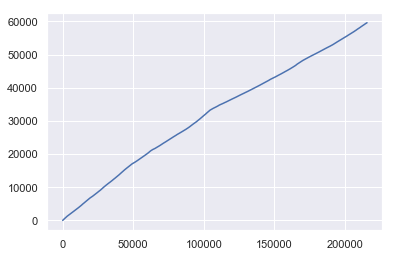

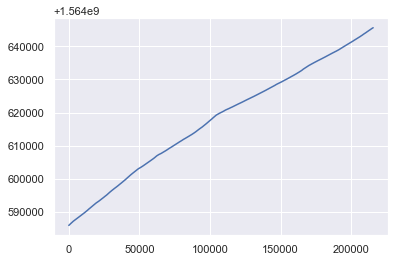

In [35]:
dst_time = dstFid.sort_values('time')
T       = dst_time.time.values
DT      = time_delta_from_time(T)
dst = dst_time.assign(DT=DT)
plt.plot(DT)
plt.show()
plt.plot(T)
plt.show()

In [36]:
kge = kr_event(dst, DT, dst.S2e, dst.S2q)

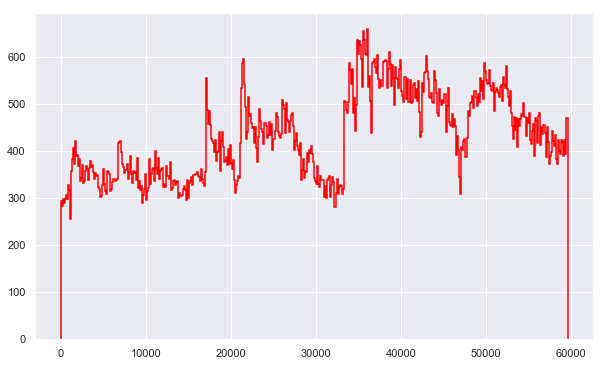

In [37]:
fig = plt.figure(figsize=(10,6))
ax      = fig.add_subplot(1, 1, 1)
(_)    = h1(kge.DT, bins=500, range = (kge.DT[0], kge.DT[-1]), color='red', stats=False, lbl='pre-sel')

### Time 

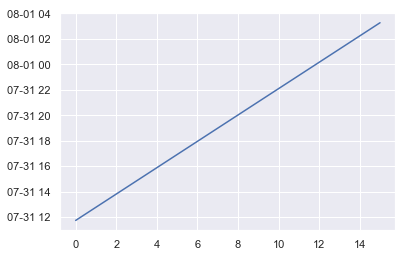

In [38]:
plt.plot(krTimes.timeStamps)

### Event distribution

In [39]:
import subprocess

bash_mkdir = "mkdir " + output_plots
process = subprocess.Popen(bash_mkdir, stdout=subprocess.PIPE, shell=True).wait()

bash_mkdir = "mkdir " + output_plots+'/EventDists/'
process = subprocess.Popen(bash_mkdir, stdout=subprocess.PIPE, shell=True).wait()

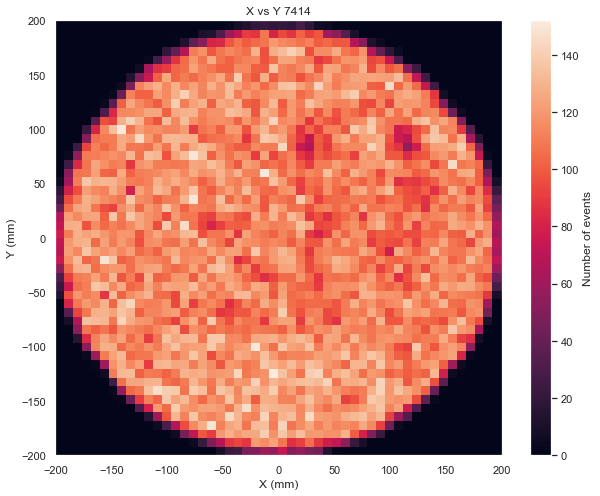

In [40]:
nevt = h2d(dst.X, dst.Y, krNbins.X, krNbins.Y, krRanges.X, krRanges.Y, 
           pltLabels=PlotLabels(x='X (mm)', y='Y (mm)', title='X vs Y '+str(run_number)),
           profile=False,
           figsize=(10,8))
plt.savefig(output_plots+'/EventDists/EventDist_'+str(run_number)+'.png')

## Time series

In [41]:
log.setLevel(logging.INFO)

### Divide dst in 100 time series

In [42]:
time_bins = 25
t0 = time.time()

RFID = 180
dstfid = dst[in_range(dst.R, 0, RFID)]
ts, masks = get_time_series_df(time_bins, (DT[0],DT[-1]), dstfid) # [edit]
t1 = time.time()
print(f' get_time_series: t = {t1 -t0}')

 get_time_series: t = 0.17139196395874023


### Fit lifetime full detector

In [43]:
t0 = time.time()
fps = time_fcs_df(ts, masks, dstfid, 
                 nbins_z = 15,
                 nbins_e = 25,
                 range_z = (10, 550),
                 range_e = (7000, 14000),
                 energy  = 'S2e',
                 fit     = FitType.profile)  # fps: fit-profile series (implicit is a time series, using profile)
t1 = time.time()
print(f' time_fcs: t = {t1 -t0}')

 time_fcs: t = 0.35792994499206543


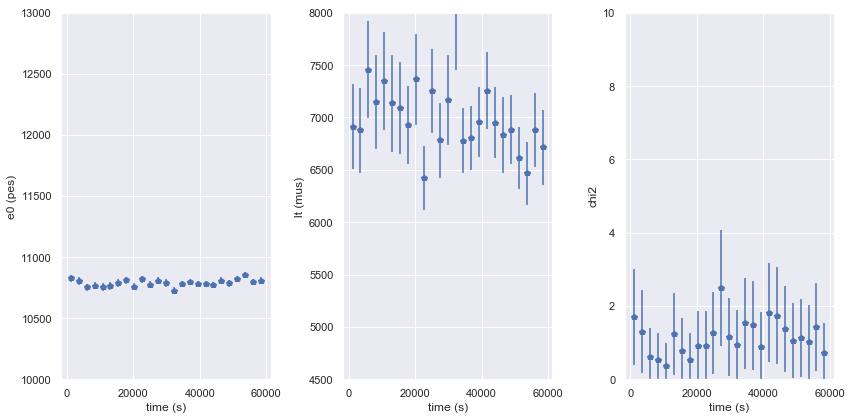

In [44]:
plot_time_fcs(fps,
              range_chi2  = (0,10),
              range_e0    = (10000, 13000),
              range_lt    = (4500, 8000),
              figsize     = (12,6))
plt.savefig(summary_outputs+'AverageLT.png')

### Fit lifetime best region

In [45]:
RINNER = 50
dst_inner = dst[in_range(dst.R, 0, RINNER)]
ts_inner, masks_inner = get_time_series_df(time_bins, (DT[0],DT[-1]), dst_inner) # [edit]

fps_inner = time_fcs_df(ts_inner, masks_inner, dst_inner, 
                 nbins_z = 15,
                 nbins_e = 25,
                 range_z = (10, 550),
                 range_e = (7000, 14000),
                 energy  = 'S2e',
                 fit     = FitType.profile)  # fps: fit-profile series (implicit is a time series, using profile)

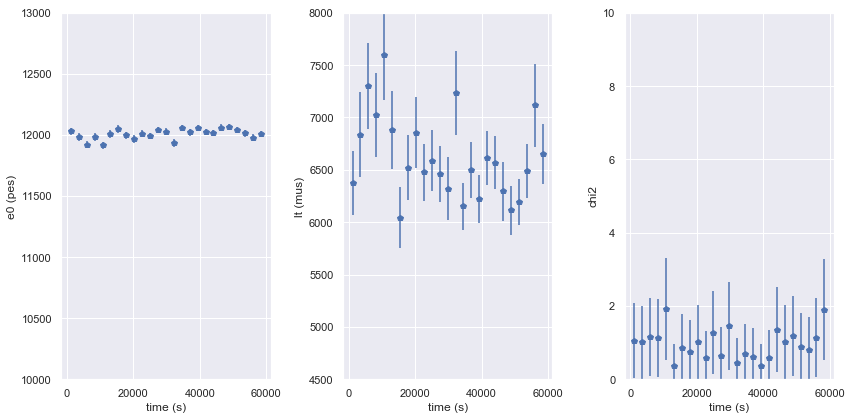

In [46]:
plot_time_fcs(fps_inner,
              range_chi2  = (0,10),
              range_e0    = (10000, 13000),
              range_lt    = (4500, 8000),
              figsize     = (12,6))
plt.savefig(summary_outputs+'AverageLT_fid.png')

## Lifetime in RPhi

In [47]:
NSECTORS =5  # number of sectors in R. Each sector then is 200 / 5 = 40 cm.
SPHI     =45 # size of the phi pie-slice in degrees, thus 10 slices in phi.
#NSECTORS =4  # number of sectors in R. Each sector then is 200 / 5 = 40 cm.
#SPHI     =45 # size of the phi pie-slice in degrees, thus 10 slices in phi.

In [48]:
rpsmd = rphi_sector_map_def(nSectors=NSECTORS, rmax=RMAX, sphi=SPHI)

In [49]:
W = define_rphi_sectors(rpsmd)

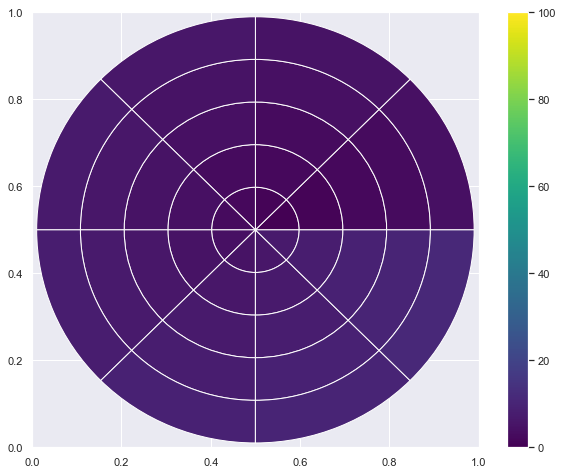

In [50]:
draw_wedges(W,  rmax = RMAX, 
            scale= 0.49, figsize=(10,8), alpha=1.0,
            cr =range(NSECTORS))

In [51]:
t0 = time.time()
#KSRP = select_rphi_sectors(dst, DT, dst.S2e, dst.S2q, W)
KSRP = select_rphi_sectors_df(dst, W) # [edit]
t1 = time.time()
print(f' KRES: t = {t1 -t0}')

 KRES: t = 0.5184059143066406


In [52]:
neM = event_map_df(KSRP)

In [53]:
neM

,0,1,2,3,4
0,1086,3450,5557,7994,9561
1,1042,3299,5687,8449,9651
2,1172,3235,5692,8351,9662
3,1008,3327,5415,7657,9368
4,1074,3112,5465,6970,9104
5,1104,3173,5189,8025,8473
6,1116,3407,5720,8131,7921
7,1071,3199,5860,7913,8954


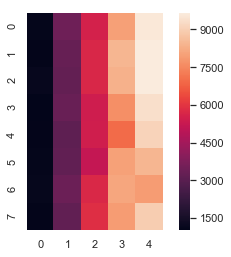

In [54]:
ax = sns.heatmap(neM, square=True)

### four phi sectors: upper half (left-right), lower half (left-right) of chamber

### R < 40 mm

In [55]:
erange = (0,14500)
ltrange = (0, 7000)

/Users/jmhaefner/Development/KryptonCalibration/KrCalibTEMP/ICAROS/krcal/core/fit_lt_histograms.py:253: RuntimeWarning: invalid value encountered in sqrt
  plt.errorbar(fp.ts, fp.lt, np.sqrt(fp.lt), fmt="p")


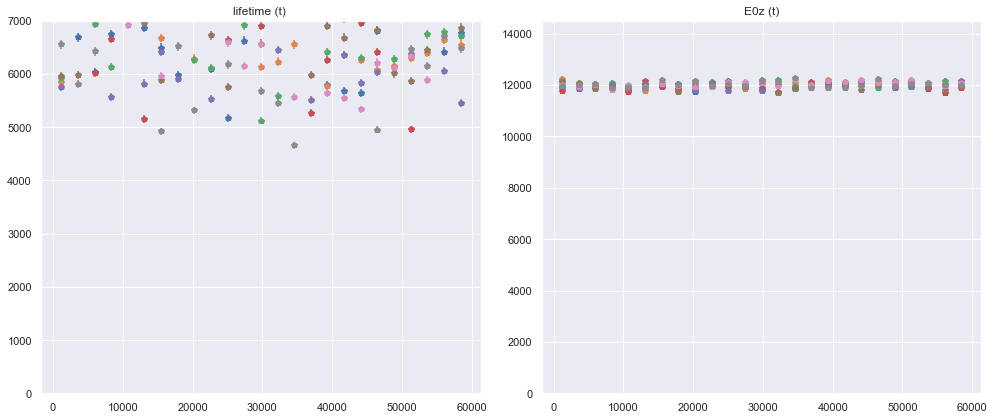

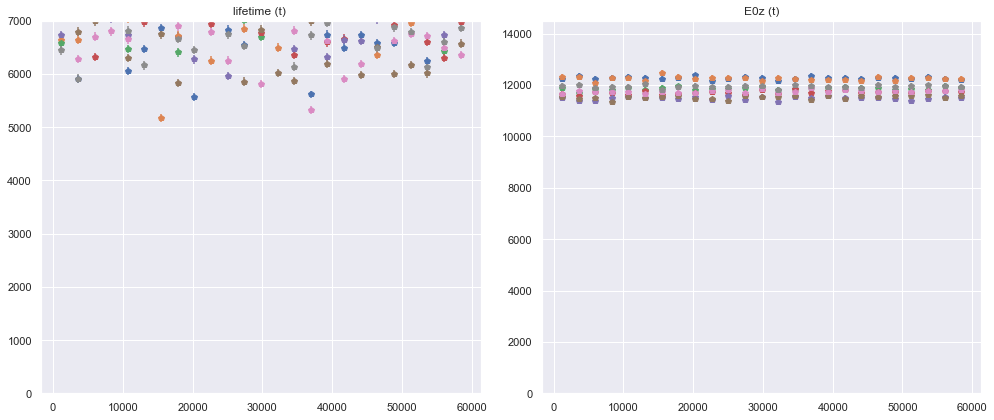

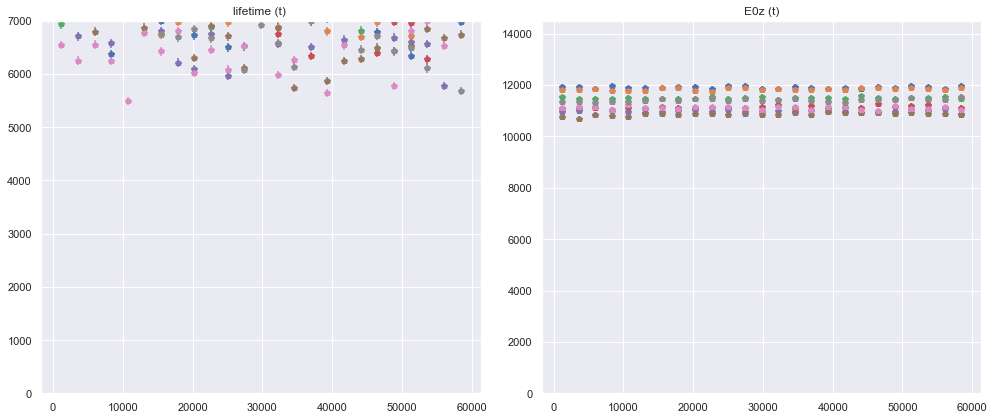

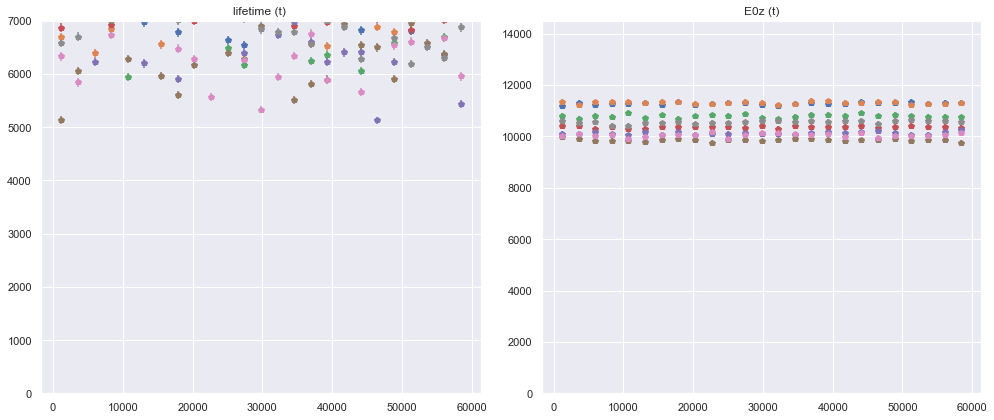

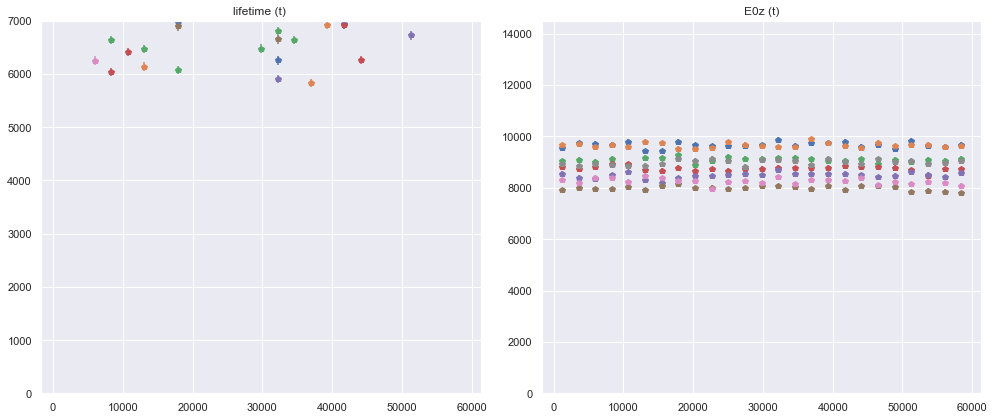

In [56]:
for sector in range(NSECTORS):
    fps_rp = fit_fcs_in_rphi_sectors_df(sector = sector,
                              selection_map = KSRP,
                              event_map     = neM,
                              n_time_bins   = time_bins,
                              time_diffs    = DT,
                              nbins_z       = 25,
                              nbins_e       = 50,
                              range_z       =(50, 550),
                              range_e       = (5000, 14500),
                              energy        = 'S2e',
                              fit           = FitType.unbined,
                              n_min         = 100)
    plot_fit_sectors(fps_rp,  range_e0 =erange, range_lt=ltrange)
    plt.savefig(summary_outputs+'R_phi_lt'+str(sector+1)+'.png')

### Lifetime patterns:

- Oscillatory pattern in time with a swing of 1 ms!
- Lifetime changes also as a function of Phi, with differences that increase as R increases.
- R > 160 cm data shows very high and very variable lifetime, with a spread of several ms.

### Strategy

- Try to correct geometrical effects first. Fine grained geometrical map with a single time bin.
- Study time dependence later

## Divide chamber in sectors of XY

In [57]:
log.setLevel(logging.DEBUG)

In [58]:
t0 = time.time()
print(len(dst))
print(len(DT))
# KRES = select_xy_sectors(dst, DT, dst.S2e.values, dst.S2q.values, krBins.X, krBins.Y)
KRES = select_xy_sectors_df(dst, krBins.X, krBins.Y) # [edit]
t1 = time.time()
print(f' KRES: t = {t1 -t0}')

215644
215644


 KRES: t = 5.080915927886963


In [59]:
log.setLevel(logging.INFO)

In [60]:
neM = event_map_df(KRES)

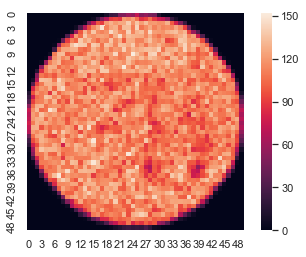

In [61]:
ax = sns.heatmap(neM, square=True)

## Fits in XY sectors

## Maps

#### fit maps. The object returned is a Dict[int, List[FitParTS]] where

```
@dataclass
class FitParTS:             # Fit parameters Time Series
    ts   : np.array          # contains the time series (integers expressing time differences)
    e0   : np.array          # e0 fitted in time series
    lt   : np.array
    c2   : np.array
    e0u  : np.array          # e0 error fitted in time series
    ltu  : np.arra`
```


### Single time bin

In [62]:
t0 = time.time()
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fpmxy = fit_map_xy_df(selection_map = KRES,
                       event_map     = neM,
                       n_time_bins   = 1,
                       time_diffs    = DT,
                       nbins_z        = krNbins.Z, 
                       nbins_e        = krNbins.S2e, 
                       range_z        = z_range, 
                       range_e        = e_range,
                       energy        = 'S2e',
                       fit           = FitType.unbined,
                       n_min         = 100)

t1 = time.time()
print(f' fpmxy: t = {t1 -t0}')

 fpmxy: t = 12.248570203781128


In [63]:
times = fpmxy[0][0].ts

In [64]:
times

array([29798.4325])

#### Obtain time maps from fmap: The object returned is a SectorMapTS
```
@dataclass
class SectorMapTS:  # Map in chamber sector containing time series of pars
    chi2  : Dict[int, List[np.array]]
    e0    : Dict[int, List[np.array]]
    lt    : Dict[int, List[np.array]]
    e0u   : Dict[int, List[np.array]]
    ltu   : Dict[int, List[np.array]]
```
Here the dictionary is arranged for each of the relevant variables.

In [65]:
tsm = tsmap_from_fmap(fpmxy)

<ErrorbarContainer object of 3 artists>

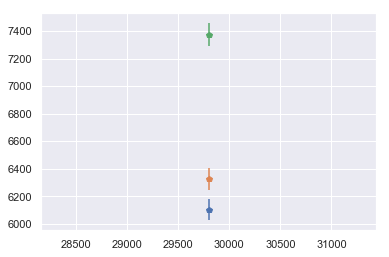

In [66]:
plt.errorbar(times, tsm.lt[25][25], np.sqrt(tsm.lt[25][25]), fmt="p")
plt.errorbar(times, tsm.lt[25][21], np.sqrt(tsm.lt[25][21]), fmt="p")
plt.errorbar(times, tsm.lt[25][22], np.sqrt(tsm.lt[25][22]), fmt="p")

<ErrorbarContainer object of 3 artists>

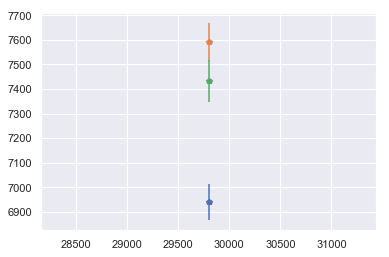

In [67]:
plt.errorbar(times, tsm.lt[30][10], np.sqrt(tsm.lt[6][10]), fmt="p")
plt.errorbar(times, tsm.lt[30][11], np.sqrt(tsm.lt[6][11]), fmt="p")
plt.errorbar(times, tsm.lt[30][12], np.sqrt(tsm.lt[6][12]), fmt="p")

### Obtain amap from tsm: The object returned is ASectorMap
```
@dataclass
class ASectorMap:  # Map in chamber sector containing average of pars
    chi2  : DataFrame
    e0    : DataFrame
    lt    : DataFrame
    e0u   : DataFrame
    ltu   : DataFrame
```
 

#### There is a single time series (ts = 0)

In [68]:
am = amap_from_tsmap(tsm, 
                     ts = 0, 
                     range_e     = e_range,
                     range_chi2  = c2_range,
                     range_lt    = lt_range)

In [69]:
amap_average(am) 

ASectorMap(chi2=1.1599229072133899, e0=10374.706513382918, lt=6766.015209725908, e0u=51.22163752504911, ltu=635.6363901395213, mapinfo=None)

#### Get rid of outlayers that distort mean and error

In [70]:
# Regularize on chi2
def asm_copy(amap):
    return ASectorMap(chi2  = amap.chi2.copy(),
                      e0    = amap.e0.copy(),
                      lt    = amap.lt.copy(),
                      e0u   = amap.e0u.copy(),
                      ltu   = amap.ltu.copy(),
                      mapinfo   = None)

def regularize_maps_chi2(amap_old, x2range):

    amap = asm_copy(amap_old)
    
    for i in range(len(amap.lt)):
        for j in range(len(amap.lt[i])):
            if amap.chi2[i][j] > x2range[1] or amap.chi2[i][j] < x2range[0]:
                amap.lt[i][j] = np.nan
                amap.ltu[i][j] = np.nan
                amap.e0[i][j] = np.nan
                amap.e0u[i][j] = np.nan

    return amap

def regularize_maps_P(amap_old, Pmap, Pmin):
    
    amap = asm_copy(amap_old)
    
    for i in range(len(amap.lt)):
        for j in range(len(amap.lt[i])):
            if Pmap[i][j] < Pmin:
                amap.lt[i][j] = np.nan
                amap.ltu[i][j] = np.nan
                amap.e0[i][j] = np.nan
                amap.e0u[i][j] = np.nan

    return amap


In [71]:
Qmap = am.chi2.copy()

from scipy import stats

for i in range(len(Qmap)):
    for j in range(len(Qmap[i])):
        if not np.isnan(Qmap[i][j]):
            Qmap[i][j] = 1-stats.chi2.cdf(Qmap[i][j] * neM[i][j], neM[i][j])

In [72]:
Qmap

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.015746e-01,7.664828e-02,...,0.000000,0.978602,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.996493,1.063709e-03,6.934570e-01,...,0.511148,0.998111,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,6.737247e-01,0.000004,9.988630e-01,9.835103e-01,...,0.146265,0.694965,9.803659e-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [73]:
Qlist = []
for x in np.array(Qmap).ravel():
    if not np.isnan(x):
        Qlist.append(x)
Qlist = np.array(Qlist)

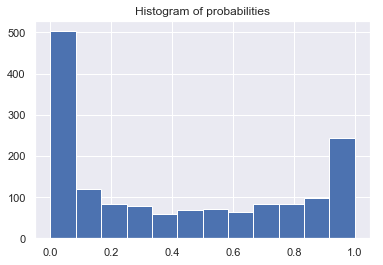

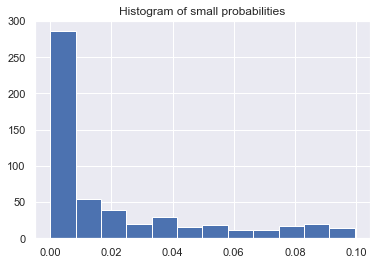

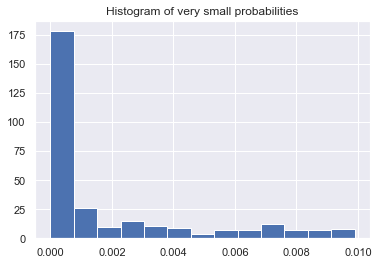

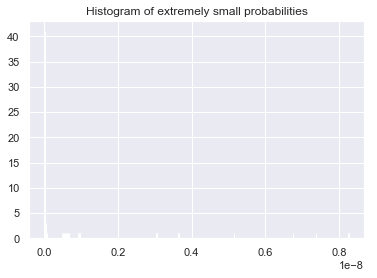

In [74]:
plt.hist(Qlist, bins='auto')
plt.title("Histogram of probabilities")
plt.show()

Qlist_small = Qlist[Qlist < 0.1]
plt.hist(Qlist_small, bins='auto')
plt.title("Histogram of small probabilities")
plt.show()

Qlist_very_small = Qlist[Qlist < 0.01]
plt.hist(Qlist_very_small, bins='auto')
plt.title("Histogram of very small probabilities")
plt.show()

Qlist_ext_small = Qlist[Qlist < 0.00000001]
plt.hist(Qlist_ext_small, bins='auto')
plt.title("Histogram of extremely small probabilities")
plt.show() 

In [75]:
# Pmin is set so that on average you should lose 1 bin per run to random fluctuations
if regularize:
    rmap = regularize_maps_P(am, Pmap = Qmap, Pmin = 1 / 2500)
    amap_average(rmap)
    asm = relative_errors(rmap)
else:
    asm = relative_errors(am)

In [76]:
amv = amap_average(asm)

#### Draw the maps using default colormap

In [77]:
bash_mkdir = "mkdir " + output_plots+'/lt_e0_xy_maps'
process = subprocess.Popen(bash_mkdir, stdout=subprocess.PIPE, shell=True).wait()

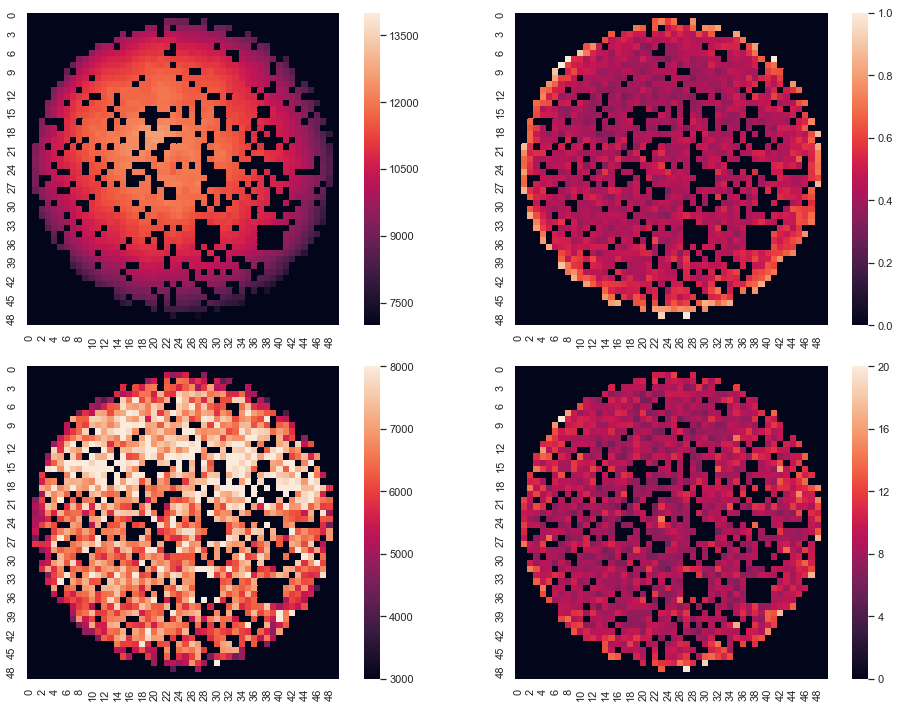

In [78]:
draw_xy_maps(asm,
            e0lims  = e0_limits,
            ltlims  = lifetime_limits,
            eulims  = (0.0,  1),
            lulims  = (0, 20),
            showPlots = False,
            figsize=(14,10))
plt.savefig(output_plots+'/lt_e0_xy_maps/lt_e0_xy_'+str(run_number)+'.png')
plt.savefig(summary_outputs+'maps.png')

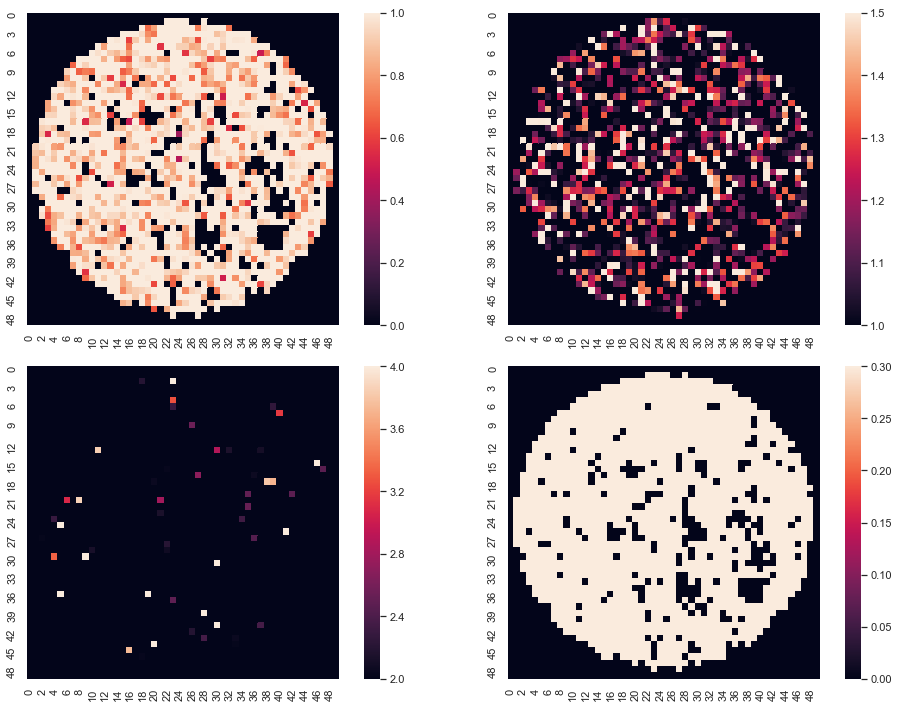

In [79]:
# Plot the X2

asmX2 = asm_copy(asm)
asmX2.e0u = asmX2.chi2.copy()
asmX2.ltu = asmX2.chi2.copy()
asmX2.lt = asmX2.chi2.copy()
asmX2.e0 = asmX2.chi2.copy()

draw_xy_maps(asmX2,
            e0lims  = (0, 1),
            ltlims  = (2, 4),
            eulims  = (1, 1.5),
            lulims  = (0, 0.3),
            showPlots = True,
            figsize=(14,10))

In [80]:
asmAv = amap_replace_nan_by_mean(asm, amMean=amv)

In [81]:
bash_mkdir = "mkdir " + output_plots + '/text_outputs'
process = subprocess.Popen(bash_mkdir, stdout=subprocess.PIPE, shell=True).wait()

In [82]:
amap_avg_list=amap_average(asmAv)

text_output = open(output_plots+'/text_outputs/outputs_'+str(run_number)+'.txt','w')

text_output.write('chi2='+str(amap_avg_list.chi2)+'\n')
text_output.write('e0='+str(amap_avg_list.e0)+'\n')
text_output.write('lt='+str(amap_avg_list.lt)+'\n')
text_output.write('e0u='+str(amap_avg_list.e0u)+'\n')
text_output.write('ltu='+str(amap_avg_list.ltu)+'\n')

mean = 0
num = 0

mean_low = 0
mean_high = 0

num_low = 0
num_high = 0

variance = 0
var_low = 0
var_high = 0

stdev = 0
stdev_low = 0
stdev_high = 0

zero_filled = asm.lt.fillna(0)
print(len(zero_filled))
for x in range(len(zero_filled)):
    ymax = len(zero_filled[x])
    for y in range(ymax):
        if (zero_filled[x][y] != 0):
            # get the mean
            mean += zero_filled[x][y]
            num += 1
            # get the means for low and high
            if y < ymax / 2:
                num_high += 1
                mean_high += zero_filled[x][y]
            else:
                num_low += 1
                mean_low += zero_filled[x][y]

mean /= num
mean_low /= num_low
mean_high /= num_high

for x in range(len(zero_filled)):
    ymax = len(zero_filled[x])
    for y in range(ymax):
        if (zero_filled[x][y] != 0):
            variance += (zero_filled[x][y] - mean)**2 / num
            if y < ymax / 2:
                var_high += (zero_filled[x][y] - mean_high)**2 / num_high
            else:
                var_low += (zero_filled[x][y] - mean_low)**2 / num_low
            
stdev = variance**0.5
stdev_low = var_low**0.5
stdev_high = var_high**0.5

mean_diff = (mean_high - mean_low) / mean


text_output.write('lt_mean_diff='+str(mean_diff)+'\n')
text_output.write('lt_mean_low='+str(mean_low)+'\n')
text_output.write('lt_mean_high='+str(mean_high)+'\n')
text_output.write('lt_stdev='+str(stdev)+'\n')
text_output.write('lt_stdev_low='+str(stdev_low)+'\n')
text_output.write('lt_stdev_high='+str(stdev_high)+'\n')

text_output.close()

amap_avg_list

50


ASectorMap(chi2=1.1607142698419717, e0=10480.492268889368, lt=6806.868625558957, e0u=0.49301620236519617, ltu=9.19796355252202, mapinfo=None)

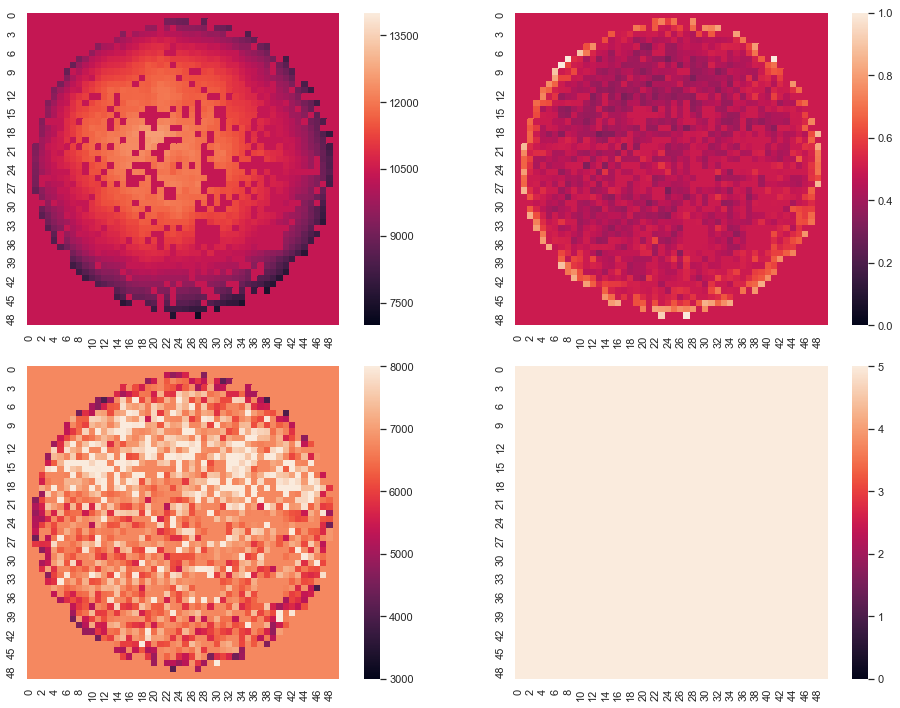

In [83]:
draw_xy_maps(asmAv,
            e0lims  = e0_limits,
            ltlims  = lifetime_limits,
            eulims  = (0.0,  1),
            lulims  = (0, 5),
            figsize=(14,10))

In [84]:
asm = add_mapinfo(asmAv, krRanges.X, krRanges.Y, krNbins.X, krNbins.Y, run_number)

In [85]:
bash_mkdir = "mkdir " + fn.emap_file_name[:fn.emap_file_name.rfind('/')]
process = subprocess.Popen(bash_mkdir, stdout=subprocess.PIPE, shell=True).wait()

In [86]:
print('The map info is:')
print(asm.mapinfo)
write_maps(asm, filename=fn.emap_file_name)

The map info is:
xmin          -200
xmax           200
ymin          -200
ymax           200
nx              50
ny              50
run_number    7414
dtype: int64


### Add temporal corrections

In [87]:
from krcal.core.kr_parevol_functions import kr_time_evolution

tmin = dst.time.min()
pars = kr_time_evolution(ts+tmin, masks, dstfid, asm, xr_map=krRanges.X, yr_map=krRanges.Y, nx_map=krNbins.X, ny_map=krNbins.Y)

pars.to_hdf(fn.emap_file_name, key='time_evolution', mode='a')

### Read back

In [88]:
emaps = read_maps(filename=fn.emap_file_name)

In [89]:
test_pars = pd.read_hdf(fn.emap_file_name, key='time_evolution')

In [90]:
test_pars

,ts,e0,e0u,lt,ltu,dv,dvu,s1w,s1wu,s1h,...,s2e,s2eu,s2q,s2qu,Nsipm,Nsipmu,Xrms,Xrmsu,Yrms,Yrmsu
0,1.564587e+09,12767.315140,18.799144,6706.838788,200.386836,0.915061,0.001306,187.345086,0.976684,2.050809,...,10330.399290,12.815300,555.210460,0.771418,19.857218,0.030391,11.742407,0.068189,11.802199,0.069387
1,1.564590e+09,12732.926113,19.402165,6962.099116,224.198621,0.911640,455.563108,187.082054,0.969065,2.039795,...,10307.286235,12.821121,554.119863,0.763094,19.803480,0.029666,11.792555,0.069795,11.812628,0.069553
2,1.564592e+09,12730.354147,18.274613,6956.559643,213.055117,0.911478,68.643668,187.582866,0.947204,2.035298,...,10293.563976,12.670294,552.743019,0.753302,19.809961,0.030286,11.922948,0.071425,11.942909,0.072886
3,1.564594e+09,12746.427293,19.011712,6726.817478,208.676503,0.914064,0.001041,187.658916,0.946022,2.026055,...,10291.021938,12.892650,552.534340,0.757762,19.809301,0.029246,11.682065,0.065923,11.861722,0.071566
4,1.564597e+09,12710.791313,19.147096,7255.897732,244.038457,0.911639,21.809527,185.776155,0.949664,2.020271,...,10295.091019,12.949119,554.269219,0.764656,19.821501,0.029510,11.821497,0.071152,11.874801,0.070287
5,1.564599e+09,12743.904926,18.082455,6789.837222,199.192714,0.914343,0.001041,188.591800,0.988620,2.038387,...,10292.519128,13.307237,551.974754,0.781174,19.813369,0.030475,11.951124,0.072075,11.999446,0.074858
6,1.564601e+09,12733.221905,19.740690,6832.354536,214.579403,0.914902,0.001202,186.763134,0.980964,2.043996,...,10301.054875,13.188691,552.994094,0.776666,19.876046,0.030688,11.612693,0.066677,11.837431,0.070870
7,1.564604e+09,12750.194114,17.252222,6695.605136,183.568176,0.914766,0.001020,187.987241,0.865144,2.049463,...,10315.731846,11.758727,554.376623,0.692854,19.820247,0.026970,11.677188,0.060199,11.851364,0.064523
8,1.564606e+09,12754.136430,18.272897,6782.581895,196.773859,0.916024,0.001171,187.248935,0.886641,2.051410,...,10291.130719,12.081055,552.411842,0.712119,19.846318,0.028248,11.777114,0.064116,11.818845,0.066329
9,1.564609e+09,12778.837701,16.178677,6403.541567,158.834993,0.912640,0.001678,188.361575,0.811380,2.065161,...,10286.333520,11.133741,552.526032,0.663833,19.848006,0.025952,11.747633,0.058758,11.787680,0.058762


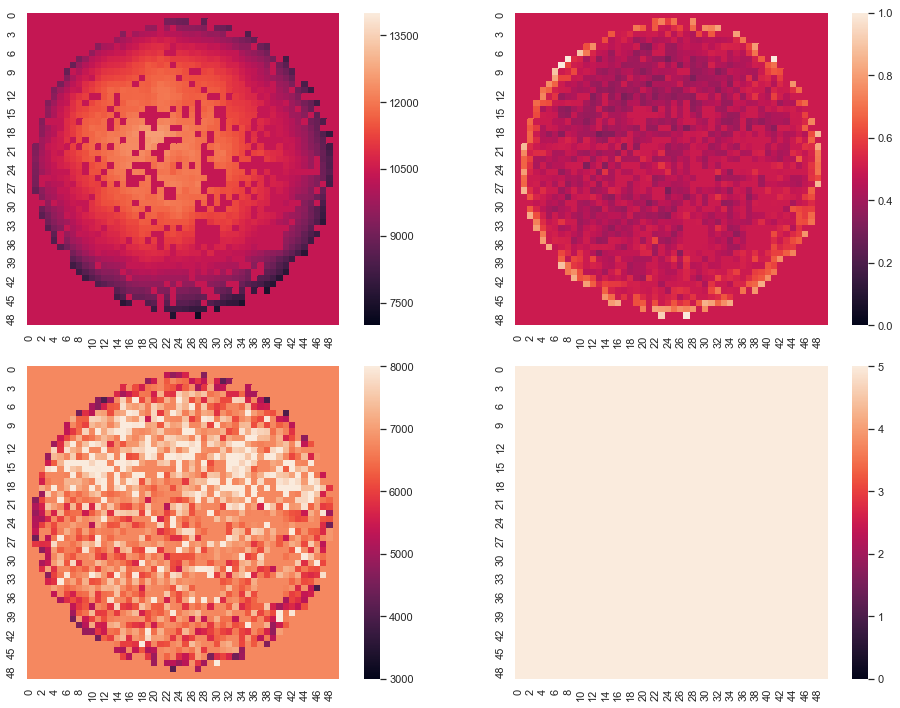

In [91]:
draw_xy_maps(emaps,
            e0lims  = e0_limits,
            ltlims  = lifetime_limits,
            eulims  = (0.0,  1),
            lulims  = (0, 5),
            figsize=(14,10))

In [92]:
amap_average(emaps)

ASectorMap(chi2=1.1607142698419717, e0=10480.492268889368, lt=6806.868625558957, e0u=0.49301620236519617, ltu=9.19796355252202, mapinfo=None)

In [93]:
norm = amap_max(emaps)

In [94]:
norm

ASectorMap(chi2=13.103458098672547, e0=12628.689642689516, lt=12839.909258967478, e0u=1.2279555437205483, ltu=28.463147506232673, mapinfo=None)

In [95]:
t0 = time.time()
E0 = e0_xy_correction(dst.S2e.values,
                      dst.X.values,
                      dst.Y.values,
                      E0M = emaps.e0 / norm.e0, 
                      xr  = krRanges.X,
                      yr  = krRanges.Y,
                      nx  = krNbins.X, 
                      ny  = krNbins.Y)


t1 = time.time()
print(f' e0 correction: t = {t1 -t0}')

 e0 correction: t = 5.347434997558594


In [96]:
t0 = time.time()
# KRP = select_rphi_sectors(dst, DT, E0, dst.S2q, W)
KRP = select_rphi_sectors_df(dst, W) # [edit]
t1 = time.time()
print(f' KRP: t = {t1 -t0}')

 KRP: t = 0.36618804931640625


In [97]:
neM = event_map_df(KRP)

In [98]:
neM

,0,1,2,3,4
0,1086,3450,5557,7994,9561
1,1042,3299,5687,8449,9651
2,1172,3235,5692,8351,9662
3,1008,3327,5415,7657,9368
4,1074,3112,5465,6970,9104
5,1104,3173,5189,8025,8473
6,1116,3407,5720,8131,7921
7,1071,3199,5860,7913,8954


In [99]:
neM[0]

0    1086
1    1042
2    1172
3    1008
4    1074
5    1104
6    1116
7    1071
Name: 0, dtype: int64

In [100]:
time_write = time.time()

## Select events in region
- r < 180
- 10 < z < 550
- 5000 < E < 14500

In [101]:
rrange = (0, 180)

ti = timeit(lt_xy_correction)
E = ti(E0, 
       dst.X.values, 
       dst.Y.values,
       dst.Z.values, 
       LTM = emaps.lt,
       xr  = krRanges.X,
       yr  = krRanges.Y,
       nx  = krNbins.X, 
       ny  = krNbins.Y)

sel = in_range(dst.R, *rrange) & in_range(dst.Z, *z_range) &  in_range(E, *e_range)
kse = kr_event(dst, DT, E, dst.S2q, sel)  # kse = krypton selected event

Time spent in lt_xy_correction: 7.402572870254517 s


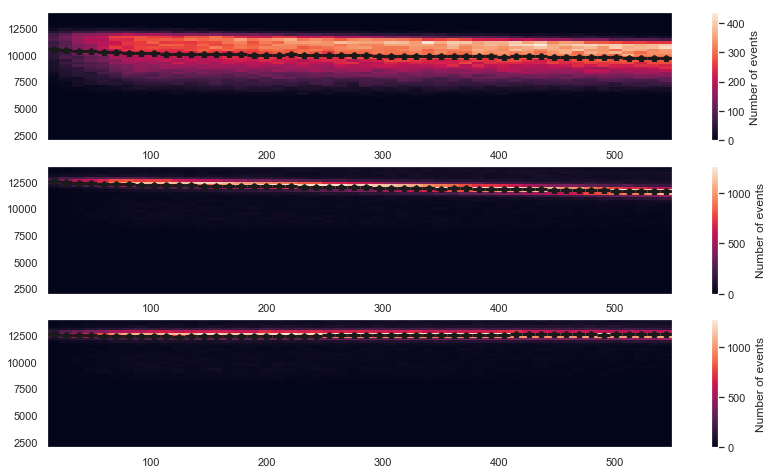

In [102]:
fig = plt.figure(figsize=(14,8))

ax      = fig.add_subplot(3, 1, 1)
nevt = h2(dst.Z, dst.S2e, 50, 50, krRanges.Z, krRanges.S2e, 
           profile=True)

ax      = fig.add_subplot(3, 1, 2)
nevt = h2(dst.Z, E0, 50, 50, krRanges.Z, krRanges.S2e, 
           profile=True)

ax      = fig.add_subplot(3, 1, 3)
nevt = h2(dst.Z, E, 50, 50, krRanges.Z, krRanges.S2e, 
           profile=True)

plt.savefig(summary_outputs+'CorrectionLT.png')

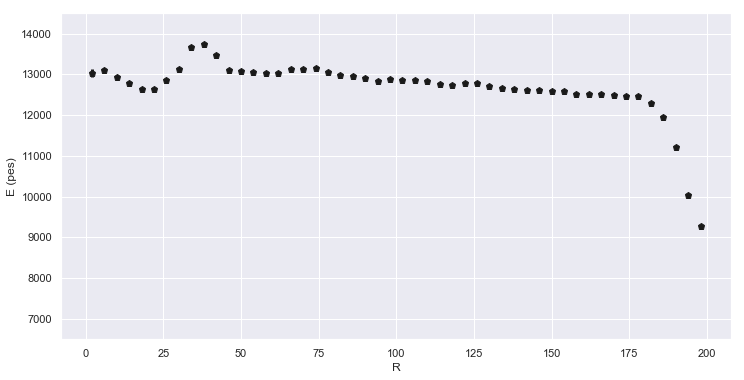

In [103]:
energy_X_profile(dst.R, E, xnbins = num_xy_bins, xrange=(0,200), xlabel = 'R',
                 erange=(6500, 14500),  
                 figsize=(12,6))
plt.savefig(summary_outputs+'RProfile.png')

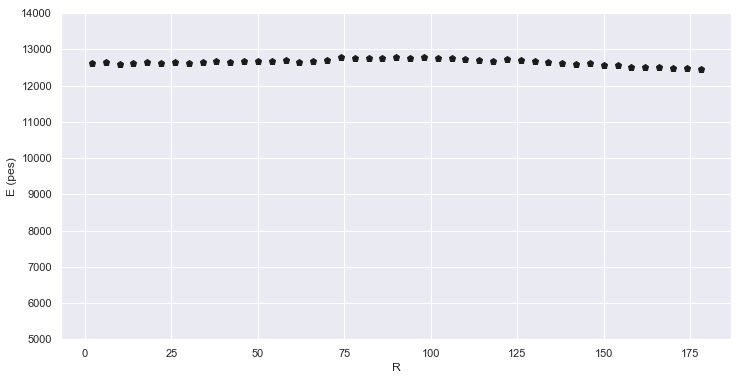

In [104]:
energy_X_profile(kse.R, kse.E, xnbins = num_xy_bins, xrange=(0,200), xlabel = 'R',
                 erange=e_range,  
                 figsize=(12,6))
plt.savefig(summary_outputs+'RProfileC.png')

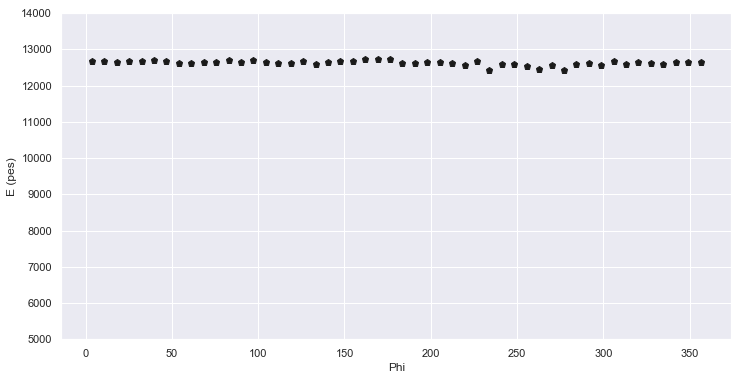

In [105]:
energy_X_profile(phirad_to_deg(kse.Phi), kse.E, xnbins = num_xy_bins, xrange=(0,360), 
                 xlabel = 'Phi',
                 erange=e_range,  
                 figsize=(12,6))
plt.savefig(summary_outputs+'PhiProfile.png')

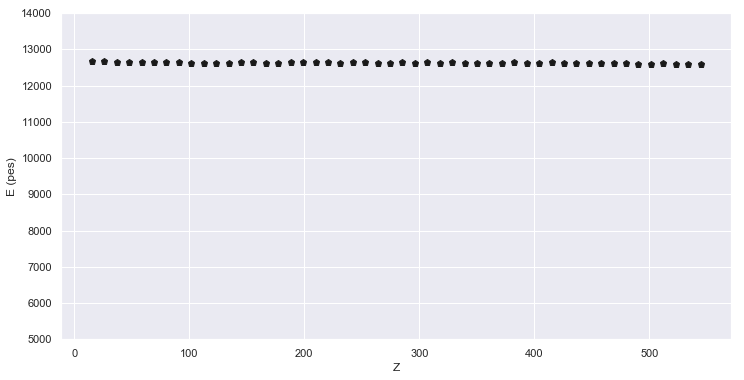

In [106]:
energy_X_profile(kse.Z, kse.E, xnbins = num_xy_bins, xrange=z_range, xlabel = 'Z',
                 erange=e_range,   
                 figsize=(12,6))
plt.savefig(summary_outputs+'ZProfile.png')

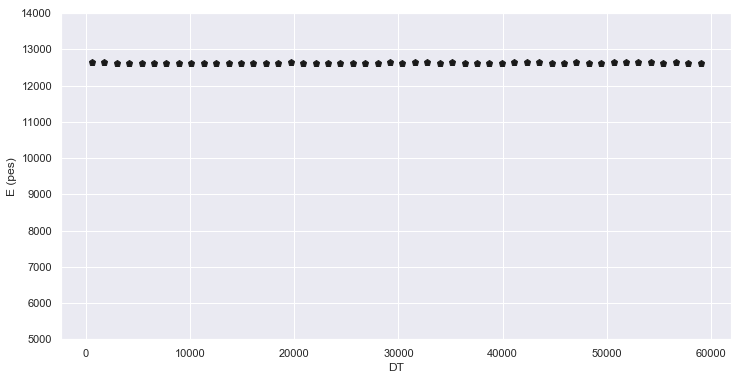

In [107]:
energy_X_profile(kse.DT, kse.E, xnbins = num_xy_bins, xrange=(kse.DT[0], kse.DT[-1]), xlabel = 'DT',
                 erange=e_range,   
                 figsize=(12,6))
plt.savefig(summary_outputs+'TProfile.png')

/Users/jmhaefner/miniconda/envs/IC-3.7-2018-11-14/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


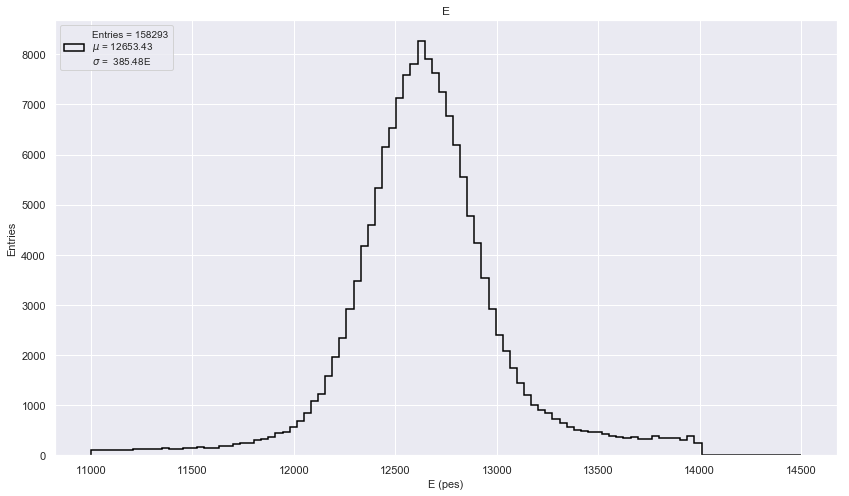

In [108]:
fig = plt.figure(figsize=(14,8))
ax      = fig.add_subplot(1, 1, 1)

(_)     = h1(kse.E,  bins = 100, range =(11000,14500), stats=True, lbl = 'E')
plot_histo(PlotLabels('E (pes)','Entries','E'), ax, legendloc='upper left')
ax      = fig.add_subplot(1, 1, 1)

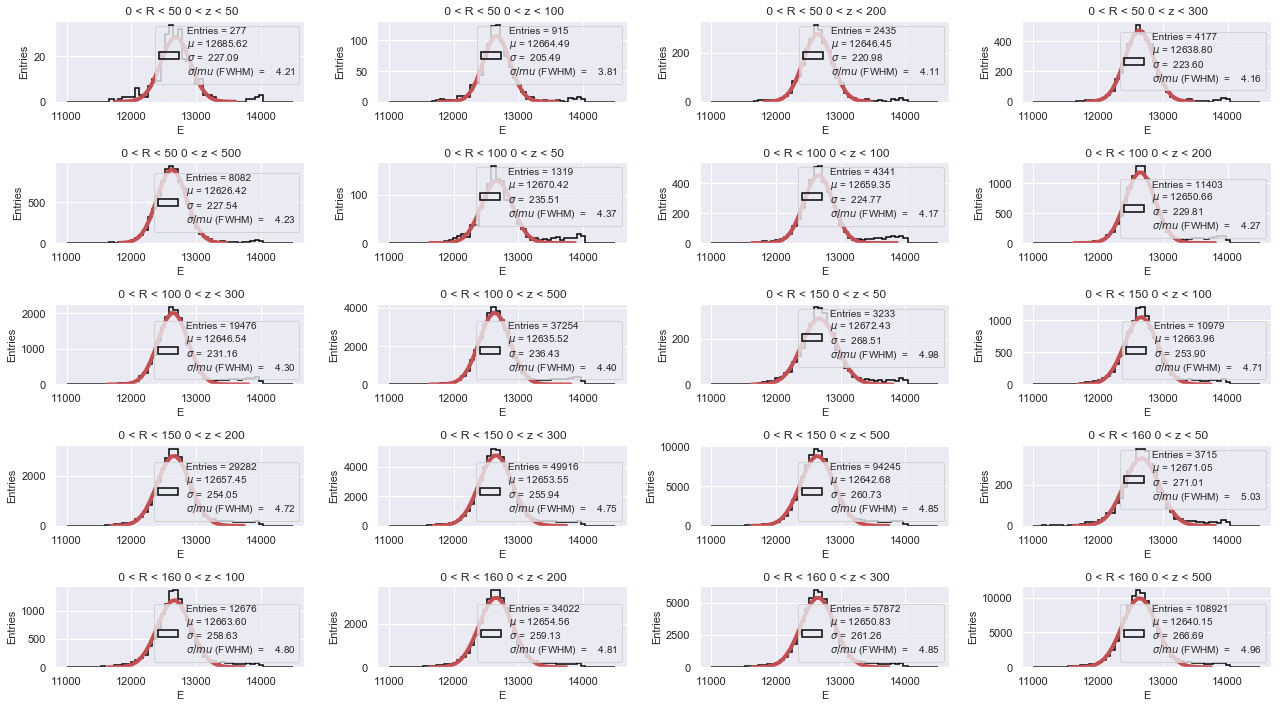

In [109]:
Ri = (50, 100,150,160)
Zi = (50, 100,200,300,500)

FC, FCE = resolution_r_z(Ri, Zi, kse.R, kse.Z, kse.E,
                    enbins = 53,
                    erange = (11e+3, 14500),
                    ixy = (5,4),
                    fdraw  = True,
                    fprint = False,
                    figsize = (18,10))

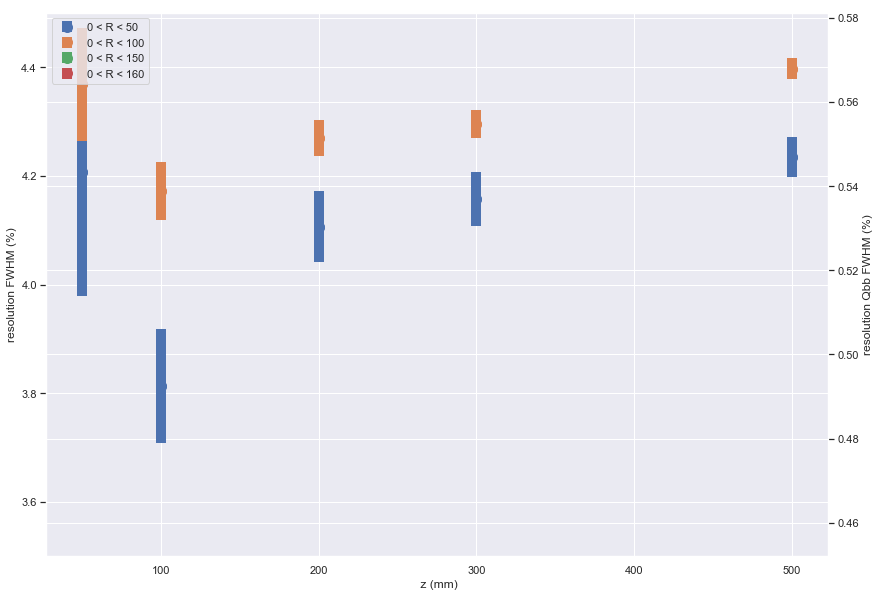

In [110]:
plot_resolution_r_z(Ri, Zi, FC, FCE)

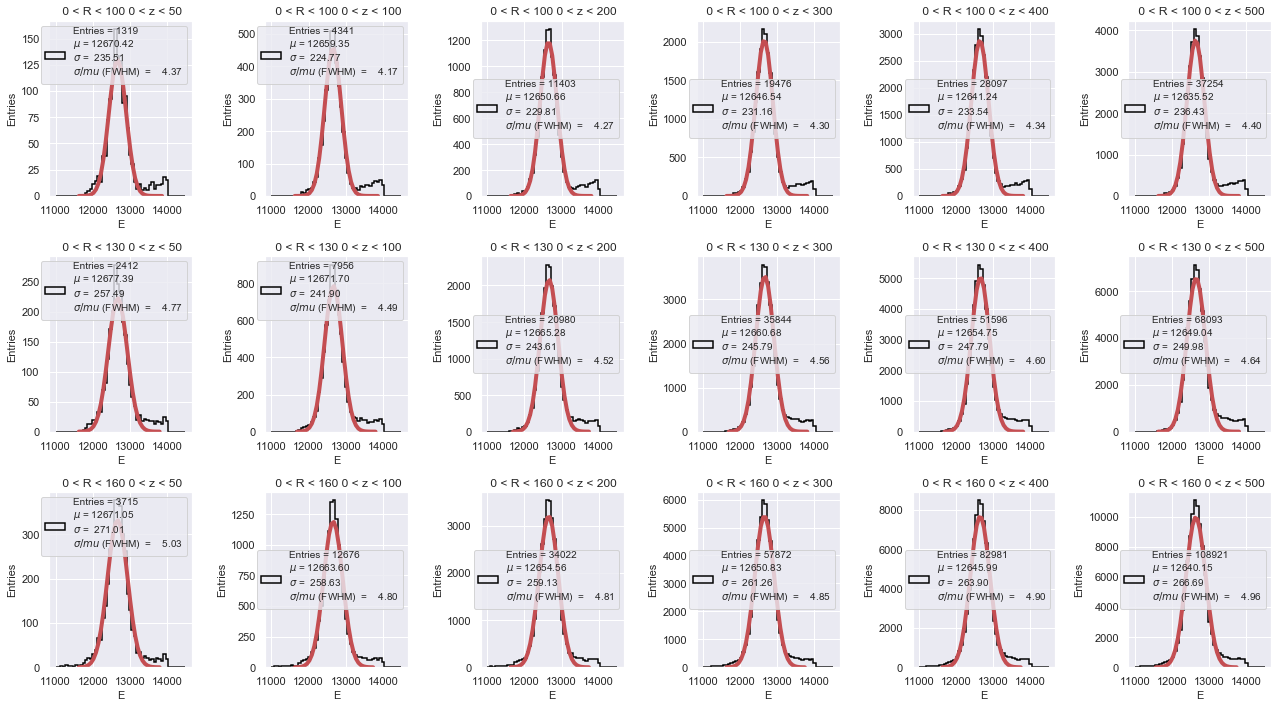

In [111]:
Ri = (100,130,160)
Zi = (50, 100,200,300,400,500)

FC, FCE = resolution_r_z(Ri, Zi, kse.R, kse.Z, kse.E,
                    enbins = 53,
                    erange = (11e+3, 14500),
                    ixy = (3,6),
                    fdraw  = True,
                    fprint = False,
                    figsize = (18,10))
plt.savefig(summary_outputs+'ResoFit.png')

In [112]:
min_res = min([min(np.array(FC).flatten())-0.1, 3.6])
max_res = max([max(np.array(FC).flatten())+0.1, 4.5])
min_res = round(10*min_res) / 10
max_res = round(10*max_res) / 10

In [113]:
bash_mkdir = "mkdir " + output_plots+'/res_vs_rz'
process = subprocess.Popen(bash_mkdir, stdout=subprocess.PIPE, shell=True).wait()

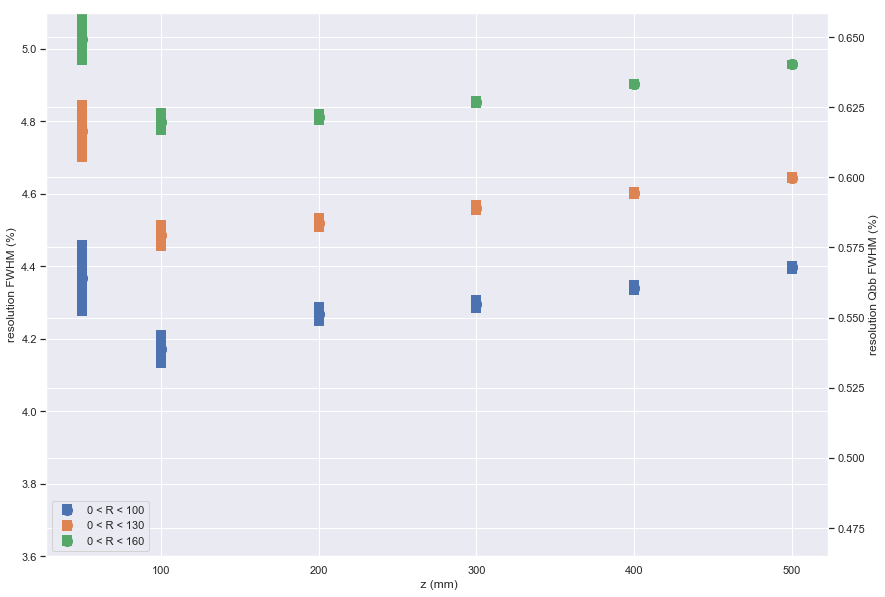

In [114]:
plot_resolution_r_z(Ri, Zi, FC, FCE, showPlots = False, r_range=(min_res, max_res))
plt.savefig(output_plots+'/res_vs_rz/res_vs_rz_'+str(run_number)+'.png')
plt.savefig(summary_outputs+'ResoVsZR.png')

In [115]:
plot_output_dir = '/Users/jmhaefner/Development/KryptonCalibration/KrCalibNB_JMH/KrCalibNB/ltMaps/plot_parameters/'
plot_outputs = open(plot_output_dir+'plot_outputs_'+str(run_number)+analysis_tag+'.txt','w+')

In [116]:
def to_output(mylist, name):
    return name+':'+str(list(mylist))+'\n'

In [117]:
plot_outputs.write(to_output(Ri, 'Ri'))
plot_outputs.write(to_output(Zi, 'Zi'))
plot_outputs.write(to_output(fps.ts, 'fps.ts'))
plot_outputs.write(to_output(fps.e0, 'fps.e0'))
plot_outputs.write(to_output(fps.e0u, 'fps.e0u'))
plot_outputs.write(to_output(fps.lt, 'fps.lt'))
plot_outputs.write(to_output(fps.ltu, 'fps.ltu'))
plot_outputs.write(to_output(fps.c2, 'fps.c2'))
plot_outputs.write(to_output(FC.values.T.tolist(), 'FC'))
plot_outputs.write(to_output(FCE.values.T.tolist(), 'FCE'))
#plot_outputs.write(to_output(kse.R, 'kse.R'))
#plot_outputs.write(to_output(kse.E, 'kse.E'))
#plot_outputs.write(to_output(kse.E, 'kse.Z'))
#plot_outputs.write(to_output(kse.DT, 'kse.DT'))
#plot_outputs.write(to_output(E, 'E'))
#plot_outputs.write(to_output(dst.Z, 'dst.Z'))
#plot_outputs.write(to_output(dst.S2e, 'dst.S2e'))
#plot_outputs.write(to_output(E0, 'E0'))
plot_outputs.close()

In [118]:
param_file = plot_output_dir+'plot_outputs_'+str(run_number)+analysis_tag+'.txt'

In [119]:
def list_params(param_file):
    params = []
    plot_params = open(param_file, 'r')
    for line in plot_params.readlines():
        params.append(line[0:line.find(':')])
    plot_params.close()
    return params

In [120]:
print(list_params(param_file))

['Ri', 'Zi', 'fps.ts', 'fps.e0', 'fps.e0u', 'fps.lt', 'fps.ltu', 'fps.c2', 'FC', 'FCE']


In [121]:
def get_param(param, param_file):
    plot_params = open(param_file, 'r')
    for line in plot_params.readlines():
        if param == line[0:line.find(':')]:
            plot_params.close()
            return(line[line.find(':')+1:len(line)-1])

In [122]:
print(get_param('Ri', param_file))

[100, 130, 160]


### Time variation monitoring plots

Plot saved to /Users/jmhaefner/Development/KryptonCalibration/KrCalibNB_JMH/KrCalibNB/doc/img/r7414Prgav190819/EffVsTime.png


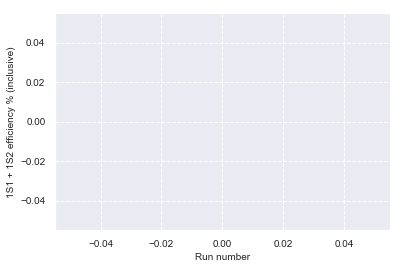

In [123]:
all_runs = []
all_fracs = []

run_min = run_number - 200
run_max = run_number + 1

for run in range(run_min, run_max):

    outer_path = '/Users/jmhaefner/Development/KryptonCalibration/KrCalibNB_JMH/KrCalibNB/doc/data_'+str(run)+analysis_tag+'/'
    full_path = outer_path +'vals_'+str(run)+'.txt'

    try:

        test_file = open(full_path, "r")
        # print(full_path)
        for line in test_file:
            if not line.find('fracS1S2') == -1:
                fracS1S2 = 100 * float(line[9:])
                # print('Frac S1 + S2 = ' + str(fracS1S2))
                all_runs.append(run)
                all_fracs.append(fracS1S2)

    except:
        pass

plt.rc('axes', titlesize = 10)
plt.rc('axes', labelsize = 10)
plt.rc('font', size=10)          # controls default text sizes
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)    # fontsize of the tick labels
plt.rc('legend', fontsize=8)    # legend fontsize
plt.rc('figure', titlesize=8)  # fontsize of the figure title

plt.grid(True)
plt.grid(linestyle='--')
plt.plot(all_runs, all_fracs, 'o')
plt.ylabel('1S1 + 1S2 efficiency % (inclusive)')
plt.xlabel('Run number')

plt.savefig(summary_outputs+'EffVsTime.png')
print('Plot saved to '+summary_outputs+'EffVsTime.png')

Plot saved to /Users/jmhaefner/Development/KryptonCalibration/KrCalibNB_JMH/KrCalibNB/doc/img/r7414Prgav190819/E0VsTime.png


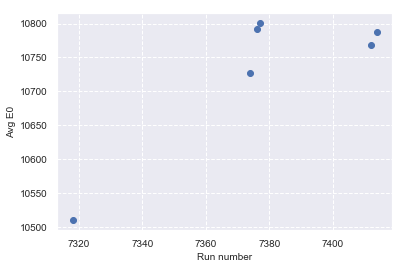

Plot saved to /Users/jmhaefner/Development/KryptonCalibration/KrCalibNB_JMH/KrCalibNB/doc/img/r7414Prgav190819/LTVsTime.png


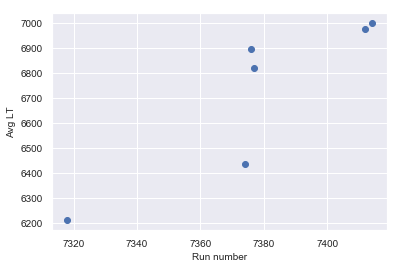

Plot saved to /Users/jmhaefner/Development/KryptonCalibration/KrCalibNB_JMH/KrCalibNB/doc/img/r7414Prgav190819/ResVsTime.png


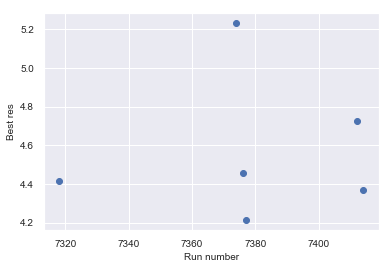

In [124]:
all_runs = []
all_e0s = []
all_lts = []
all_res = []

run_min = run_number - 200
run_max = run_number + 1

for run in range(run_min, run_max):

    outer_path = '/Users/jmhaefner/Development/KryptonCalibration/KrCalibNB_JMH/KrCalibNB/ltMaps/plot_parameters/'
    full_path = outer_path + 'plot_outputs_'+str(run)+analysis_tag+'.txt'
        
    try:
        test_file = open(full_path, "r")
        all_runs.append(run)
        for line in test_file:
            if line.find('fps.e0:') != -1:
                all_e0s.append(np.mean(eval(line[7:])))
            if line.find('fps.lt:') != -1:
                all_lts.append(np.mean(eval(line[7:])))
            if line.find('FC:') != -1:
                all_res.append(eval(line[3:])[0][0])
                # fracS1S2 = 100 * float(line[9:])
                # print('Frac S1 + S2 = ' + str(fracS1S2))
                # all_runs_s1s2.append(run)
                # all_fracs.append(fracS1S2)

    except:
        pass

plt.rc('axes', titlesize = 10)
plt.rc('axes', labelsize = 10)
plt.rc('font', size=10)          # controls default text sizes
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)    # fontsize of the tick labels
plt.rc('legend', fontsize=8)    # legend fontsize
plt.rc('figure', titlesize=8)  # fontsize of the figure title

plt.grid(True)
plt.grid(linestyle='--')

plt.plot(all_runs, all_e0s, 'o')
plt.ylabel('Avg E0')
plt.xlabel('Run number')
plt.savefig(summary_outputs+'E0VsTime.png')
print('Plot saved to '+summary_outputs+'E0VsTime.png')
plt.show()

plt.plot(all_runs, all_lts, 'o')
plt.ylabel('Avg LT')
plt.xlabel('Run number')
plt.savefig(summary_outputs+'LTVsTime.png')
print('Plot saved to '+summary_outputs+'LTVsTime.png')
plt.show()

plt.plot(all_runs, all_res, 'o')
plt.ylabel('Best res')
plt.xlabel('Run number')
plt.savefig(summary_outputs+'ResVsTime.png')
print('Plot saved to '+summary_outputs+'ResVsTime.png')
plt.show()

In [125]:
dt_write = time_write - t_start
dt_plots = time.time() - time_write
print('Time to write =', round(dt_write/60.0,1), 'm')
print('Time to show plots =', round(dt_plots/60.0,1), 'm')

Time to write = 1.1 m
Time to show plots = 0.6 m
